`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   

**Выполнил студент ПМИ3-1 Поталайнен Илья**

**Вариант: 15**

# Лабораторная работа №2: Линейные модели. Кросс-валидация

*Данные*: `College_for_lab` (источник: <https://github.com/aksyuk/MTML/blob/main/Labs/data/College_for_lab.csv>)

### Зависимая и объясняющие переменные

* Зависимая: `Grad_Rate` — выпускной балл.
* Объясняющие:
    + `Top25perc` — процент зачисленных студентов, которые в старшей школе относились к топ-25% в диапазоне по освоению; 
    + `F_Undergrad` —  количество студенческой формы обучения; 
    + `Private` — частный или государственный университет: 
        - Да - частный, 
        - Нет - государственный.

In [244]:
# настройка ширины страницы блокнота .......................................
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Загрузка пакетов

In [245]:
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
#  тест Шапиро-Уилка на нормальность распределения
from scipy.stats import jarque_bera
#  для таймера
import time

# загрузка пакетов: модели -------------------------------------------------
#  линейные модели
import sklearn.linear_model as skl_lm
#  расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut 
from sklearn.model_selection import KFold, cross_val_score
#  полиномиальные модели
from sklearn.preprocessing import PolynomialFeatures

### Константы

In [246]:
#  ядро для генератора случайных чисел
my_seed = 15
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot

### Загрузка данных

In [247]:
fileURL = 'https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/College_for_lab.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (777, 9)


In [248]:
# первые 5 строк фрейма
DF_raw.head(5)

,Grad_Rate,Accept,Top10perc,Top25perc,F_Undergrad,P_Undergrad,PhD,Expend,Private
0,60,1232,23,52,2885,537,70,7041,Yes
1,56,1924,16,29,2683,1227,29,10527,Yes
2,54,1097,22,50,1036,99,53,8735,Yes
3,59,349,60,89,510,63,92,19016,Yes
4,15,146,16,44,249,869,76,10922,Yes


In [249]:
# типы столбцов фрейма
DF_raw.dtypes

Grad_Rate       int64
Accept          int64
Top10perc       int64
Top25perc       int64
F_Undergrad     int64
P_Undergrad     int64
PhD             int64
Expend          int64
Private        object
dtype: object

Проверим данные на наличие пропусков

In [250]:
# считаем пропуски в каждом столбце
DF_raw.isna().sum()

Grad_Rate      0
Accept         0
Top10perc      0
Top25perc      0
F_Undergrad    0
P_Undergrad    0
PhD            0
Expend         0
Private        0
dtype: int64

Пропусков не обнаружено.  

До проведения анализа данных необходимо разделить фрейм на две части: 80% выборки будет использовано в качестве обучающей выборки для моделей, в то время как 20% будет применено для прогнозирования на наилучшей модели.

In [251]:
DF_raw = DF_raw[['Grad_Rate', 'Top25perc', 'F_Undergrad', 'Private']]
DF_raw.head()

,Grad_Rate,Top25perc,F_Undergrad,Private
0,60,52,2885,Yes
1,56,29,2683,Yes
2,54,50,1036,Yes
3,59,89,510,Yes
4,15,44,249,Yes


In [252]:
# замена строковых значений на числовые
DF['Private'] = DF['Private'].replace({'Yes': 1, 'No': 0})

In [253]:
DF.head(10)

,Grad_Rate,Top25perc,F_Undergrad,Private,log_Grad_Rate,Top25perc_Private,FUndergrad_Private
728,90,93,4879,1,4.499810,93,4879
353,66,51,1452,1,4.189655,51,1452
175,78,63,1028,1,4.356709,63,1028
654,55,67,6635,0,4.007333,0,0
94,75,49,2159,1,4.317488,49,2159
690,47,68,2936,1,3.850148,68,2936
206,46,35,3793,0,3.828641,0,0
497,67,67,4576,1,4.204693,67,4576
619,66,85,24470,0,4.189655,0,0
735,64,25,2961,1,4.158883,25,2961


In [254]:
DF_predict.head(10)

,Grad_Rate,Top25perc,F_Undergrad,Private
0,60,52,2885,1
1,56,29,2683,1
14,55,46,1317,1
15,69,22,1018,1
17,59,40,1819,1
19,34,54,4190,0
23,48,49,22593,0
27,69,57,16262,0
29,71,69,1950,1
34,85,61,2718,1


## Предварительный анализ данных   

### Расчет описательных статистик   

Далее будут рассчитаны описательные статистики для непрерывных переменных.

### Построение графиков взаимного разброса

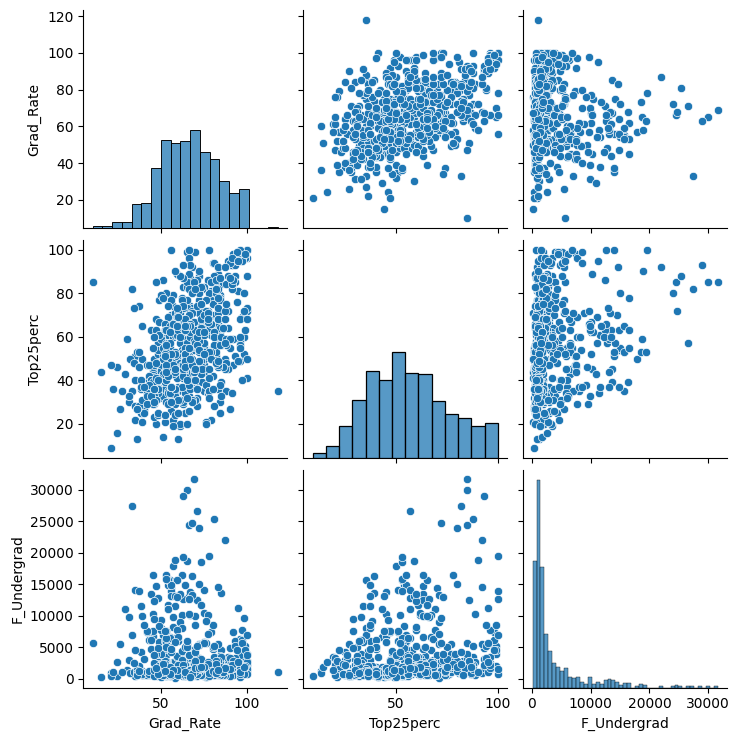

In [255]:
# матричный график разброса с линиями регрессии
sns.pairplot(DF[['Grad_Rate', 'Top25perc', 'F_Undergrad']])
plt.show()

### Интерпретация результатов визуального анализа
* распределение зависимой переменной `Grad_Rate` приближено к нормальному;
* распределение независимой переменной `Top25perc` приближено к нормальному;
* распределение независимой переменной `F_Undergrad` не приближено к нормальному;
* с ростом независимой переменной `Top25perc` наблюдается рост зависимой `Grad_Rate`, что свидетельствует о наличии средней положительной корреляции между этими факторами;
* на диаграммах разброса `F_Undergrad` vs `Grad_Rate` и `F_Undergrad` vs `Top25perc` присутствуют наблюдения, группирующиеся на удалении от основного набора данных; данные наблюдения могут исказить параметры модели и привести к неверным статистическим выводам.

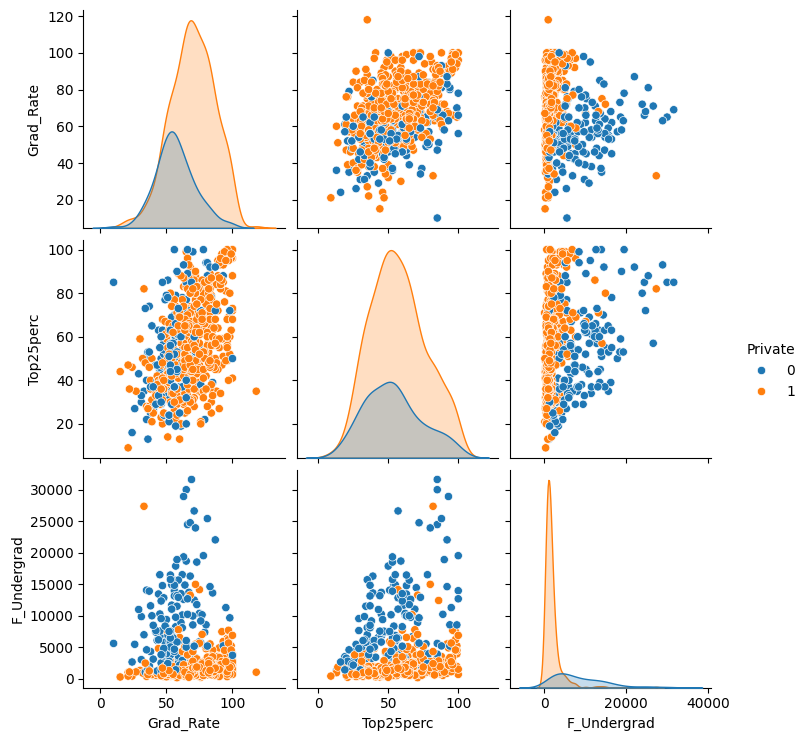

In [256]:
sns.pairplot(DF[['Grad_Rate', 'Top25perc', 'F_Undergrad', 'Private']],
            hue='Private')

plt.show()

Оранжевые и синие точки визуально распределены равномерно. Оранжевые точки смещены влево по `F_Undergrad`, поскольку частные университеты являются более специализированными, то есть имеют меньшее число форм обучения, нежели государственные. В остальном явных тенденций не обнаружено.

Далее осуществлен поиск сомнительных значений, значительно отличающихся от остального набора данных. Для этого были построены коробчатые диаграммы, которые позволяют визуально оценить наличие потенциальных выбросов в данных. В случае обнаружения таких наблюдений, будет применено статистическое тестирование на аномальность сомнительных значений.

<Axes: >

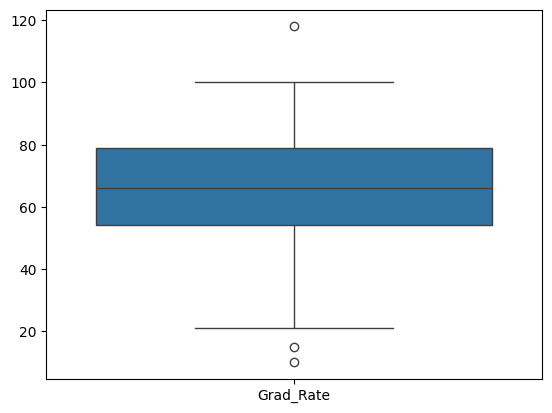

In [257]:
sns.boxplot(data=DF[['Grad_Rate']])

<Axes: >

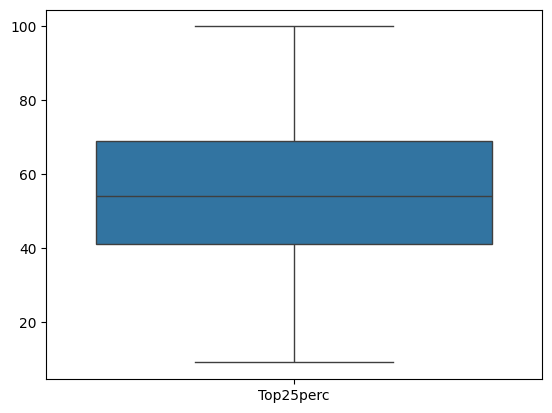

In [258]:
sns.boxplot(data=DF[['Top25perc']])

<Axes: >

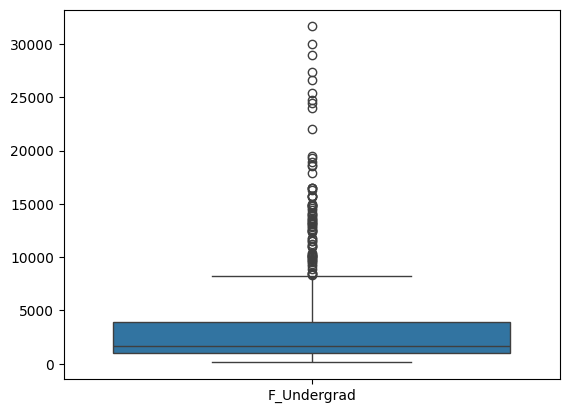

In [259]:
sns.boxplot(data=DF[['F_Undergrad']])

<p>Исходя из диаграмм видно, что в показателях <code>Grad_Rate</code> и <code>F_Undergrad</code> присутствуют наблюдения, вызывающие сомнение.
Поскольку при визуальном анализе возникли предположения о наличии выбросов, произведена проверка этих значений на аномальность посредством статистического теста Титьена-Мура. В отличие от теста Граббса, данный критерий позволяет обнаруживать не только одиночные аномальные значения, но и группы выбросов, удаленные от основной части наблюдений.
Расчетное значение теста Титьена-Мура для выявления выбросов в верхней части ранжированного ряда данных вычисляется по формуле:</p>
<center>$L=\dfrac{\sum_{i=1}^{n-k}(x_i - \overline{x_k})^2}{\sum_{i=1}^{n}(x_i - \overline{x})^2}$,</center>
<p>где:</p>
<ul>
    <li>$k$ – число наблюдений с резко отклоняющимися значениями признака;</li>
    <li>$x_k$ – среднее, рассчитанное по $n–k$ наблюдениям, оставшимся после отбрасывания $k$ сомнительных значений «сверху» ранжированного ряда данных.</li>
</ul>
Расчетное значение теста Титьена-Мура для выявления выбросов в нижней части ранжированного ряда данных вычисляется по формуле:
<center>$L'=\dfrac{\sum_{i=k+1}^{n-k}(x_i - \overline{x_k})^2}{\sum_{i=1}^{n}(x_i - \overline{x})^2}$</center>
<p>Если $L<L_{кр}$, то ошибки в данных признаются грубыми, в ином случае данные типичны для данной совокупности.</p>

Обнаружение сомнительных значений реализовано посредством метода межквартильного размаха (Interquartile Range, $IQR$). Далее реализован класс для вычисления $L$-критерия.

In [260]:
class LCriterion:
    def __init__(self, data):
        self.data = data
        self.boundsCalculation()
        self.result = self.criterionCalculation()
        
    def boundsCalculation(self):
        Q1 = self.data.quantile(0.25)
        Q3 = self.data.quantile(0.75)

        IQR = Q3 - Q1

        self.lowerBound = Q1 - 1.5 * IQR
        self.upperBound = Q3 + 1.5 * IQR

    def criterionCalculation(self):
        cleanedData = self.data[(self.data >= self.lowerBound) & (self.data <= self.upperBound)]

        mean = self.data.mean()
        meanCleanedData = cleanedData.mean()

        squaredDeviations = np.sum((self.data - mean)**2)
        squaredDeviationsCD = np.sum((cleanedData - meanCleanedData)**2)

        return f'Количество сомнительных значений: {self.data.count() - cleanedData.count()}\nРасчетное значение L-критерия: {np.round(squaredDeviationsCD / squaredDeviations, 2)}'

<ul>
    <li><code>Q1 = data.quantile(0.25)</code> – первый квартиль, который разделяет 25% значений выборки снизу;</li>
    <li><code>Q3 = data.quantile(0.75)</code> – третий квартиль, который разделяет 25% значений выборки сверху;</li>
    <li><code>IQR = Q3 - Q1</code> – разница между третьим и первым квартилями, характеризующая интерквартильный размах, в котором содержится центральные 50% данных;</li>
    <li><code>lowerBound</code> и <code>upperBound</code> – нижняя и верхняя границы, определяющие минимальное и максимальное значение соответственно для выявления выбросов.</li>
</ul>

<h3>Расчет $L$-критерия для показателя <code>F_Undergrad</code></h3>

In [261]:
print(LCriterion(DF['F_Undergrad']).result)

Количество сомнительных значений: 77
Расчетное значение L-критерия: 0.11


Критическое значение при уровне значимости $\alpha=0,05$, количестве наблюдений $n = 777$ и количестве сомнительных значений $k = 77$ равно $L_{0,05;777;77} \approx 0,356$. Поскольку расчетное значение критерия оказалось меньше критического, то в рамках теста Титьена-Мура достаточные доказательства для подтверждения того, что данные значения могут быть признаны аномальными, присутствуют, и отсеченные наблюдения являются выбросами.

<h3>Расчет $L$-критерия для показателя <code>Grad_Rate</code></h3>

In [262]:
print(LCriterion(DF['Grad_Rate']).result)

Количество сомнительных значений: 3
Расчетное значение L-критерия: 0.95


Значение $L$-критерия, близкое к единице, указывает на то, что сумма квадратов разностей по очищенным данным и исходным данным практически не отличается. Это свидетельствует о том, что удаление сомнительных значений не сильно влияет на общее распределение данных и не меняет характеристики центральной тенденции. Таким образом, можно заключить, что рассматриваемые сомнительные значения представляют собой типичные значения для данной совокупности.

In [263]:
DFWA = DF[
    (DF['F_Undergrad'] >= DF['F_Undergrad'].quantile(0.25) - 1.5 * (DF['F_Undergrad'].quantile(0.75) - DF['F_Undergrad'].quantile(0.25))) &
    (DF['F_Undergrad'] <= DF['F_Undergrad'].quantile(0.75) + 1.5 * (DF['F_Undergrad'].quantile(0.75) - DF['F_Undergrad'].quantile(0.25)))
].copy()

<h3>Корреляционный анализ</h3>

Осуществлено построение корреляционных матриц на:

<h4>а) исходных данных</h4>

In [264]:
correlationMatrix = DF[['Grad_Rate', 'Top25perc', 'F_Undergrad']].corr()
correlationMatrix.style.background_gradient(cmap='coolwarm')

,Grad_Rate,Top25perc,F_Undergrad
Grad_Rate,1.000000,0.460691,-0.077523
Top25perc,0.460691,1.000000,0.214729
F_Undergrad,-0.077523,0.214729,1.000000


Без разбиения на классы наблюдений по фиктивной переменной максимальная тесноса линейной взаимосвязи соответствует коэффициенту корреляции $\rho($<code>GradRate</code>$;$<code>Top25perc</code>$) = 0,46$. Далее посчитаны корреляционные матрицы с учетом формы собственности университетов (частный/государственный):

In [265]:
correlationMatrix = DF.loc[DF['Private'] == 1][['Grad_Rate', 'Top25perc', 'F_Undergrad']].corr()
correlationMatrix.style.background_gradient(cmap='coolwarm')

,Grad_Rate,Top25perc,F_Undergrad
Grad_Rate,1.000000,0.480889,0.142861
Top25perc,0.480889,1.000000,0.317057
F_Undergrad,0.142861,0.317057,1.000000


In [266]:
correlationMatrix = DF.loc[DF['Private'] == 0][['Grad_Rate', 'Top25perc', 'F_Undergrad']].corr()
correlationMatrix.style.background_gradient(cmap='coolwarm')

,Grad_Rate,Top25perc,F_Undergrad
Grad_Rate,1.000000,0.413433,0.270152
Top25perc,0.413433,1.000000,0.441283
F_Undergrad,0.270152,0.441283,1.000000


Видно, что при наличии частной формы владения <code>Private</code>$ = 1$ выросла взаимосвязь между <code>Grad_Rate</code> и <code>Top25perc</code>, в то время как при наличии государственной формы владения <code>Private</code>$= 0$ эта взаимосвязь уменьшилась, но увеличилась корреляция между <code>Grad_Rate</code> и <code>F_Undergrad</code>.

<h4>б) очищенных данных</h4>

In [267]:
correlationMatrix = DFWA[['Grad_Rate', 'Top25perc', 'F_Undergrad']].corr()
correlationMatrix.style.background_gradient(cmap='coolwarm')

,Grad_Rate,Top25perc,F_Undergrad
Grad_Rate,1.000000,0.489227,0.008563
Top25perc,0.489227,1.000000,0.152700
F_Undergrad,0.008563,0.152700,1.000000


Удаление аномальных значений в столбце <code>F_Undergrad</code> поспособствовало незначительному усилению линейной взаимосвязи зависимой переменной с факторами. 

In [268]:
correlationMatrix = DFWA.loc[DF['Private'] == 1][['Grad_Rate', 'Top25perc', 'F_Undergrad']].corr()
correlationMatrix.style.background_gradient(cmap='coolwarm')

,Grad_Rate,Top25perc,F_Undergrad
Grad_Rate,1.000000,0.492757,0.324453
Top25perc,0.492757,1.000000,0.393166
F_Undergrad,0.324453,0.393166,1.000000


In [269]:
correlationMatrix = DFWA.loc[DF['Private'] == 0][['Grad_Rate', 'Top25perc', 'F_Undergrad']].corr()
correlationMatrix.style.background_gradient(cmap='coolwarm')

,Grad_Rate,Top25perc,F_Undergrad
Grad_Rate,1.000000,0.272982,0.047609
Top25perc,0.272982,1.000000,0.098195
F_Undergrad,0.047609,0.098195,1.000000


Выводы по корреляционным матрицам после классового разбиения остались неизменными, и тенденции остаются схожими. Однако при <code>Private</code>$= 0$ связь стала относительно ниже, а при <code>Private</code>$ = 1$ — теснее.

<h3>Оценка соответствия зависимой переменной нормальному закону</h3>

Важным допущением линейной регрессии является нормальность распределения зависимой переменной. Поскольку возникли сомнения относительно выполнения этого предположения, был применен тест Джарка-Бера для проверки нормальности `Grad_Rate`. Этот тест предпочтителен при работе с большим объемом данных и менее чувствителен к колебаниям по сравнению с тестом Шапиро-Уилка. Тест проведен также и на логарифмированных данных. Предварительно выдвинута пара гипотез: $H_0: y_i  ~ N(0,σ^2)$ при конкурирующей $H_1: y_i⊄N(0, σ^2)$. 

In [270]:
if (DF['Grad_Rate'] <= 0).any():
    print("Обнаружены отрицательные значения или '0' в столбце 'Grad_Rate'")

else:
    print("Отрицательные значения и '0' не обнаружены в столбце 'Grad_Rate'")

    DF['log_Grad_Rate'] = np.log(DF['Grad_Rate'])

    for col in ['Grad_Rate', 'log_Grad_Rate']:
        _, p = jarque_bera(DF[col])
    
        print(np.round(p, 4))
    
        if p > 0.05:
            print('H0: распределение нормально')
        else:
            print('H1: распределение не нормально')

Отрицательные значения и '0' не обнаружены в столбце 'Grad_Rate'
0.3112
H0: распределение нормально
0.0
H1: распределение не нормально


Поскольку распределение зависимой переменной является нормальным, нет смысла применять логарифмирование или прочие преобразования. 

<h3>Построение моделей</h3>

Можно составить следующие линейные спецификации модели:

<ol>
    <li>$GradRate = Private + Top25perc + FUndergrad$</li>
    <li>$GradRate = Private + Top25perc \times Private + FUndergrad$</li>
    <li>$GradRate = Private + Top25perc + FUndergrad \times Private$</li>
    <li>$GradRate = Private + Top25perc \times Private + FUndergrad \times Private$</li>
</ol>

In [271]:
class LinearModelSelector:
    def __init__(self, data):
        self.data = data

    def prepareData(self):
        self.data['Top25perc_Private'] = self.data['Top25perc'] * self.data['Private']
        self.data['FUndergrad_Private'] = self.data['F_Undergrad'] * self.data['Private']

        self.X1 = self.data[['Private', 'Top25perc', 'F_Undergrad']]
        self.X2 = self.data[['Private', 'Top25perc_Private', 'F_Undergrad']]
        self.X3 = self.data[['Private', 'Top25perc', 'FUndergrad_Private']]
        self.X4 = self.data[['Private', 'Top25perc_Private', 'FUndergrad_Private']]
        self.y = self.data['Grad_Rate']

    def trainTestSplit(self, test_size=0.2, random_state=42):
        self.X1_train, self.X1_test, self.y_train, self.y_test = train_test_split(self.X1, self.y, test_size=test_size, random_state=random_state)
        self.X2_train, self.X2_test, _, _ = train_test_split(self.X2, self.y, test_size=test_size, random_state=random_state)
        self.X3_train, self.X3_test, _, _ = train_test_split(self.X3, self.y, test_size=test_size, random_state=random_state)
        self.X4_train, self.X4_test, _, _ = train_test_split(self.X4, self.y, test_size=test_size, random_state=random_state)

    def createModels(self):
        self.models = [
            LinearRegression(),
            LinearRegression(),
            LinearRegression(),
            LinearRegression()
        ]

        self.formulas = [
            'Grad_Rate = Private + Top25perc + F_Undergrad',
            'Grad_Rate = Private + Top25perc * Private + F_Undergrad',
            'Grad_Rate = Private + Top25perc + F_Undergrad * Private',
            'Grad_Rate = Private + Top25perc * Private + F_Undergrad * Private'
        ]

    def evaluateModels(self):
        for i, model in enumerate(self.models):
            X_train = [self.X1_train, self.X2_train, self.X3_train, self.X4_train][i]
            X_test = [self.X1_test, self.X2_test, self.X3_test, self.X4_test][i]
            scores = cross_val_score(model, X_train, self.y_train, cv=5, scoring='neg_mean_squared_error')
            MSE = -scores.mean()  
            print(f'Модель {i+1}: {self.formulas[i]}')
            print(f'Обучающая выборка MSE: {np.round(MSE, 2)}')
            model.fit(X_train, self.y_train)
            testMSE = mean_squared_error(self.y_test, model.predict(X_test))
            print(f'Тестовая выборка MSE: {np.round(testMSE, 2)}')
            print('---')

    def selectBestModel(self):
        self.bestModelIndex = np.argmin([mean_squared_error(self.y_test, model.predict(X_test)) for model, X_test in zip(self.models, [self.X1_test, self.X2_test, self.X3_test, self.X4_test])])
        self.bestModel = self.models[self.bestModelIndex]
        self.bestFormula = self.formulas[self.bestModelIndex]

    def trainBestModel(self):
        self.bestModel.fit([self.X1_train, self.X2_train, self.X3_train, self.X4_train][self.bestModelIndex], self.y_train)

    def predictBestModel(self):
        self.predictedValues = self.bestModel.predict([self.X1_test, self.X2_test, self.X3_test, self.X4_test][self.bestModelIndex])

    def printBestModelInfo(self):
        print(f'Наиболее точная модель: {self.bestFormula}')
        print(f'Тестовая выборка MSE для наиболее точной модели: {np.round(mean_squared_error(self.y_test, self.predictedValues), 2)}')

    def printBestModelCoefficients(self):
        print("Коэффициенты наиболее точной модели:")
        for coef, feature in zip(self.bestModel.coef_, self.X1_train.columns):
            print(f"{feature}: {np.round(coef, 4)}")

    def calculateErrorInPercentage(self):
        meanY = np.mean(self.y_test)
        relativeError = mean_squared_error(self.y_test, self.predictedValues) / meanY
        print(f"Относительная ошибка модели на отложенных наблюдениях: {relativeError:.2f}%")

<h3>Описание класса</h3>

<ul>
    <li><code>prepareData</code> — метод для подготовки данных, в котором создаются новые переменные на основе существующих, необходимых для построения моделей;</li>
    <li><code>trainTestSplit(self, test_size=0.2, random_state=42)</code> метод для разделения данных на обучающую и тестовую выборки; параметры<code>test_size</code> и <code>random_state</code> используются для управления размером тестовой выборки и для воспроизводимости результатов;</li>
    <li><code>createModels</code> — метод для создания моделей; создаются экземпляры <code>LinearRegression()</code> для каждой из четырех моделей;</li>
    <li><code>evaluateModels</code> — метод для оценки моделей, выполняет оценку каждой модели на обучающей и тестовой выборках с использованием метода перекрестной проверки K-VAL (K-fold cross-validation) и выводящий среднее значение MSE для обучающей выборки и значение MSE для тестовой выборки для каждой модели;</li>
    <li><code>selectBestModel</code> — метод для выбора наиболее точной модели, в котором выбирается модель с наименьшим значением MSE на тестовой выборке;</li>
    <li><code>trainBestModel</code> — метод для обучения выбранной наиболее точной модели на всей обучающей выборке;</li>
    <li><code>predictBestModel</code> — метод для прогнозирования с помощью выбранной наиболее точной модели на тестовой выборке;</li>
    <li><code>printBestModelInfo</code> — метод для вывода информации о наиболее точной модели;</li>
    <li><code>printBestModelCoefficients</code> — метод для вывода коэффициентов наиболее точной модели;</li>
    <li><code>calculateErrorInPercentage</code> — метод для вычисления относительной ошибки на отложенных наблюдениях.</li>
</ul>

<h3>Расчеты на исходных данных</h3>

In [272]:
modelSelector = LinearModelSelector(DF)
modelSelector.prepareData()
modelSelector.trainTestSplit()
modelSelector.createModels()
modelSelector.evaluateModels()
modelSelector.selectBestModel()
modelSelector.trainBestModel()
modelSelector.predictBestModel()
modelSelector.printBestModelInfo()
modelSelector.printBestModelCoefficients()
modelSelector.calculateErrorInPercentage()

Модель 1: Grad_Rate = Private + Top25perc + F_Undergrad
Обучающая выборка MSE: 215.33
Тестовая выборка MSE: 196.67
---
Модель 2: Grad_Rate = Private + Top25perc * Private + F_Undergrad
Обучающая выборка MSE: 223.52
Тестовая выборка MSE: 200.25
---
Модель 3: Grad_Rate = Private + Top25perc + F_Undergrad * Private
Обучающая выборка MSE: 213.44
Тестовая выборка MSE: 230.9
---
Модель 4: Grad_Rate = Private + Top25perc * Private + F_Undergrad * Private
Обучающая выборка MSE: 227.85
Тестовая выборка MSE: 222.94
---
Наиболее точная модель: Grad_Rate = Private + Top25perc + F_Undergrad
Тестовая выборка MSE для наиболее точной модели: 196.67
Коэффициенты наиболее точной модели:
Private: 15.387
Top25perc: 0.3751
F_Undergrad: 0.0003
Относительная ошибка модели на отложенных наблюдениях: 2.90%


<h4>Интерпретация</h4>

Параметры можно интерпретировать следующим образом:

1. У студентов из частных университетов выпускные баллы в среднем на $15,387$ выше, чем у студентов из государственных.
2. При увеличении на единицу процента зачисленных студентов, которые в старшей школе относились к топ-25% в диапазоне по освоению (`Top25perc`), выпускной балл увеличится в среднем на $0,3751$.
3. При увеличении числа форм обучения (`F_Undergrad`) на единицу, выпуксной балл увеличится в среднем на $0,0003$.

<h3>Расчеты на очищенных данных</h3>

In [273]:
modelSelector = LinearModelSelector(DFWA)
modelSelector.prepareData()
modelSelector.trainTestSplit()
modelSelector.createModels()
modelSelector.evaluateModels()
modelSelector.selectBestModel()
modelSelector.trainBestModel()
modelSelector.predictBestModel()
modelSelector.printBestModelInfo()
modelSelector.printBestModelCoefficients()
modelSelector.calculateErrorInPercentage()

Модель 1: Grad_Rate = Private + Top25perc + F_Undergrad
Обучающая выборка MSE: 206.09
Тестовая выборка MSE: 217.73
---
Модель 2: Grad_Rate = Private + Top25perc * Private + F_Undergrad
Обучающая выборка MSE: 211.87
Тестовая выборка MSE: 201.15
---
Модель 3: Grad_Rate = Private + Top25perc + F_Undergrad * Private
Обучающая выборка MSE: 205.64
Тестовая выборка MSE: 213.11
---
Модель 4: Grad_Rate = Private + Top25perc * Private + F_Undergrad * Private
Обучающая выборка MSE: 211.87
Тестовая выборка MSE: 197.97
---
Наиболее точная модель: Grad_Rate = Private + Top25perc * Private + F_Undergrad * Private
Тестовая выборка MSE для наиболее точной модели: 197.97
Коэффициенты наиболее точной модели:
Private: -7.3196
Top25perc: 0.3542
F_Undergrad: 0.0017
Относительная ошибка модели на отложенных наблюдениях: 2.99%


<h4>Интерпретация</h4>

Параметры можно интерпретировать следующим образом:

1. У студентов из частных университетов выпускные баллы в среднем на $7,3196$ ниже, чем у студентов из государственных.
2. При увеличении на единицу процента зачисленных студентов, которые в старшей школе относились к топ-25% в диапазоне по освоению (`Top25perc`), выпускной балл увеличится в среднем на $0,3542$.
3. При увеличении числа форм обучения (`F_Undergrad`) на единицу, выпуксной балл увеличится в среднем на $0,0017$.

При повторном анализе диаграмм разброса по классам `Private`, в частности зависимости `F_Undergrad` vs `Grad_Rate`, наблюдается явная тенденция: более высокие значения `Grad_Rate` связаны с категорией `Private` $= 1$, в то время как высокие значения `F_Undergrad` характерны для случаев, когда `Private` $= 0$. Однако после очистки данных от выбросов по столбцу `F_Undergrad`, данная тенденция стала несостоятельной, на что указывает отрицательное значение фиктивной переменной. Следовательно, модель, построенная на очищенных данных, не может считаться статистически достоверной.